In [ ]:
!pip install seaborn
!pip install captum
!pip install seaborn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sb
torch.manual_seed(0)

In [3]:
dataset=sb.load_dataset('flights')
print(dataset.head(12))
print(len(dataset))

    year month  passengers
0   1949   Jan         112
1   1949   Feb         118
2   1949   Mar         132
3   1949   Apr         129
4   1949   May         121
5   1949   Jun         135
6   1949   Jul         148
7   1949   Aug         148
8   1949   Sep         136
9   1949   Oct         119
10  1949   Nov         104
11  1949   Dec         118
144


In [4]:
#from that we build our own training data with a sliding window of length 10
targets,features=[],[]
for i in range(10,len(dataset)):
  target=dataset['passengers'][i]
  targets.append(target)
  feature=dataset['passengers'][i-10:i]
  features.append(feature)


feature_tensor=torch.Tensor(features).float()
target_tensor=torch.Tensor(targets).float()

In [5]:
#normalize the data
mean_f=torch.mean(feature_tensor)
std_f=torch.std(feature_tensor)
feature_tensor=(feature_tensor-mean_f)/std_f

mean_t=torch.mean(target_tensor)
std_t=torch.std(target_tensor)
target_tensor=(target_tensor-mean_f)/std_f

In [6]:
print(feature_tensor[0])
print(target_tensor[0])

tensor([-1.4712, -1.4177, -1.2929, -1.3196, -1.3910, -1.2662, -1.1503, -1.1503,
        -1.2572, -1.4088])
tensor(-1.5425)


In [8]:
#randomly split training and test set
training_part=round(len(feature_tensor)*0.9)
print(training_part)

shuffled_index=torch.randperm(len(features))
training_index=shuffled_index[:training_part]
validation_index=shuffled_index[training_part:len(feature_tensor)]


train_f,train_t=feature_tensor[training_index],target_tensor[training_index]
val_f,val_t=feature_tensor[validation_index],target_tensor[validation_index]

121


In [9]:
import torch.optim as optim
#define a network, loss function and optimizer

class RegModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1=nn.Linear(10,3)
    self.sig1=nn.Sigmoid()
    self.lin2=nn.Linear(3,1)

  def forward(self,x):
    z=self.lin1(x)
    z=self.sig1(z)
    z=self.lin2(z)
    return z

model=RegModel()
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(),lr=0.00001)

In [ ]:
import copy
epochs=150000
best_val_loss=10**10

for epoch in range(epochs):
  pred=model(train_f).squeeze()
  loss=loss_func(pred,train_t)
  loss.backward()
  opt.step()

  #calculate validation loss
  val_loss=loss_func(model(val_f).squeeze(),val_t)

  if val_loss<best_val_loss:
    best_val_loss=val_loss
    best_model=copy.deepcopy(model)
    inc_count=0
  else:
    inc_count+=1
  if inc_count >225:
    model=best_model
    break

  model.zero_grad()
  if epoch%(epochs/100) == 0:
    print('training loss: ',loss,'  validation loss: ',val_loss)


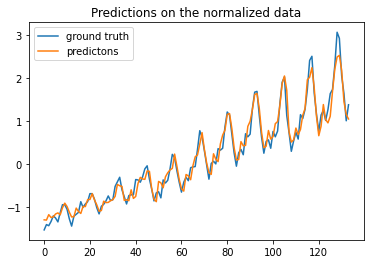

In [11]:
#visualize model performance

full_predictions=model(feature_tensor).detach()

import matplotlib.pyplot as plt

plt.plot(target_tensor,label='ground truth')
plt.plot(full_predictions,label='predictons')
plt.title('Predictions on the normalized data')
plt.legend()
plt.show()

In [13]:
#try some captum methods on the model
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
import numpy as np

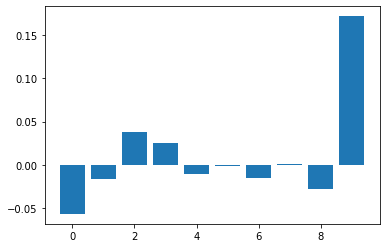

In [14]:
intgrad = IntegratedGradients(model)
feature_tensor.requires_grad_()
attr, delta = intgrad.attribute(feature_tensor, return_convergence_delta=True)
attr = attr.detach().numpy()

importance=np.mean(attr,axis=0)

x_i=np.arange(len(importance))

plt.bar(x_i,importance)
plt.legend('average feature importance')
plt.show()

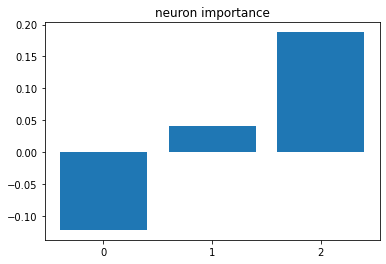

In [15]:
cond = LayerConductance(model, model.lin1)
cond_vals = cond.attribute(feature_tensor)
cond_vals = cond_vals.detach().numpy()
cond_vals = np.mean(cond_vals,axis=0)

x_i=np.arange(len(cond_vals))
plt.bar(x_i,cond_vals)
plt.title('neuron importance')
plt.xticks(x_i)
plt.show()

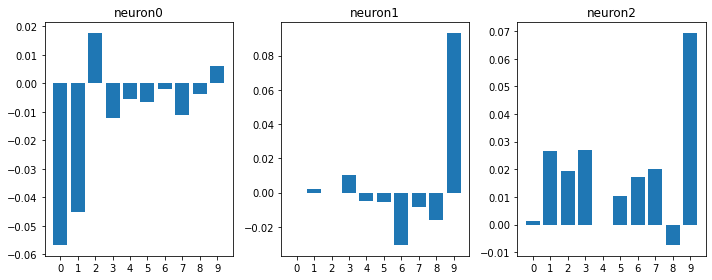

In [16]:
#lets look closer at the neurons
fig = plt.figure(figsize=(10, 4))

for neuron_index in range(3):

  neuron_cond = NeuronConductance(model, model.lin1)
  neuron0_cond = neuron_cond.attribute(feature_tensor, neuron_selector=neuron_index)
  neuron0_cond = np.mean(neuron0_cond.detach().numpy(),axis=0)

  plt.subplot(130+neuron_index+1)
  x_i=np.arange(len(neuron0_cond))
  plt.bar(x_i,neuron0_cond)
  plt.title('neuron'+str(neuron_index))
  plt.xticks(x_i)

plt.tight_layout()
plt.show()

So here we can see that for neuron 1 and 2 the feature 10 is most imoprtant. These two neurons have little to no negative correlation to the inputs, while neuron0 almost exclusively has negative correlations to the input. Also considering the figure "neuron importance" from before, it seems as if neuron 0 is focussing on predicting a decrease, while the other two have learned features that predict an increase in the passenger numbers.

The main takeaway is that input 10 is the most important positive correlation for the output. That may be because the number of recorded flight passengers  most of the time was around the number of the month before.
